# 1. Load and Understand the Dataset

In [1]:
#Importing the necessary libraries to notebook 

import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC, SVC

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB
from collections import Counter
from mlxtend.plotting import plot_decision_regions

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, precision_recall_curve, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
def evaluate_model(model, X, y, pred_label=1):

    """
    This function evaluates your model and interprets the classification metrics results in a DataFrame format.
    
    Input
    ---------
    model: Classification Model
    X: Features
    y: Label
    pred_label: Which label will be used for interprets the results
        
    Output
    -------
    metric_df: Result DataFrame
    """
    
    y_pred = model.predict(X)

    accuracy = round(accuracy_score(y, y_pred), 3)
    recall = round(recall_score(y, y_pred, pos_label = pred_label), 3)
    precision = round(precision_score(y, y_pred, pos_label = pred_label), 3)
    f1 = round(f1_score(y, y_pred, pos_label = pred_label), 3)
    auc_score = round(roc_auc_score(y, y_pred), 3)

    metric_df = pd.DataFrame([accuracy, recall, precision, f1, auc_score]).T
    metric_df.index = ["Class " + str(pred_label)]
    metric_df.columns = ["Accuracy", "Recall", "Precision", "F1 Score", "AUC Score"]

    return metric_df

In [3]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = [4,3], fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to [12,8].
    fontsize: int
        Font size for axes labels. Defaults to 18.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
    plt.figure(figsize=figsize)
    
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [4]:
df =pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
df.drop_duplicates(inplace=True)

In [6]:
df.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

In [7]:
# In the Age column there are unexpected strokes that we saw in the real early ages (babies). Interesting !!
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [8]:
# Look at the data types and empty cells
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [9]:
#Looks like we have 201 empty cells in the BMI column.
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [10]:
df['gender'].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

In [11]:
df['smoking_status'].value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: count, dtype: int64

In [12]:
df['stroke'].value_counts()

stroke
0    4861
1     249
Name: count, dtype: int64

In [13]:
df['work_type'].value_counts()

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: count, dtype: int64

In [14]:
count_work = sum(value == 'Never_worked' for value in df['work_type'])
print(count_work)

filtered_rows = df[df['work_type'] == 'Never_worked' ]
filtered_rows_count_work = sum(value == 0 for value in filtered_rows['work_type'])
print(filtered_rows_count_work)

22
0


In [15]:
filtered_rows

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
253,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
603,61408,Male,23.0,0,0,No,Never_worked,Urban,125.26,18.7,never smoked,0
886,13948,Female,19.0,0,0,No,Never_worked,Urban,86.96,25.8,never smoked,0
939,16556,Male,13.0,0,0,No,Never_worked,Rural,111.48,20.8,Unknown,0
959,56986,Male,17.0,0,0,No,Never_worked,Urban,113.25,23.4,never smoked,0
1462,41870,Male,17.0,0,0,No,Never_worked,Rural,61.01,32.5,Unknown,0
1789,13862,Female,13.0,0,0,No,Never_worked,Urban,70.93,22.9,never smoked,0
1922,51935,Male,16.0,0,0,No,Never_worked,Urban,59.99,28.2,never smoked,0
2346,61219,Female,14.0,0,0,No,Never_worked,Urban,148.37,22.7,never smoked,0
2721,23508,Female,17.0,0,0,No,Never_worked,Rural,88.57,31.1,never smoked,0


**Predictions About The Dataset**

1. ever_married column  :  This can be a possible impact on the health. Regular life / sleeping times etc. 
2. work_type : This might be an idication for a stress level that give us an idication. Self employed might be more stressful life compared to private compant employed.
3. residence_type : Urban life style can be positive or negative. Not so clear
    a. Urban areas might be less stressfull that have a positive impact compared the Rural areas.
    b. On th other hand,hard to access to health services and regular/quick checks can be negative. 
4. smoking_type : This should be the biggest impact on the stroke status. If not than it is a problem.
5. bmi : This column is an good idication for us to assign the status of the person but should be used like down below beacuse we have babies and adults in the same results. 
    *     If your BMI is less than 18.5 = underweight range.
    *     If your BMI is 18.5 to <25 =  healthy weight range. 
    *     If your BMI is 25.0 to <30 = overweight range. 
    *     If your BMI is 30.0 or higher = obesity range
6. gender : It feels like men more likely to have strokes compared to women.
7. avg_glucose_level : This columne gives us an idication of the status of the diabetes status of the patient.
    *     less than 100 - normal
    *     Between 100 and 125 - prediabetes
    *     Equal or higher 126 - diabetes 

***We will try to discover all of these in the EDA section.***

# 2. EDA (Explotary Data Analysis)

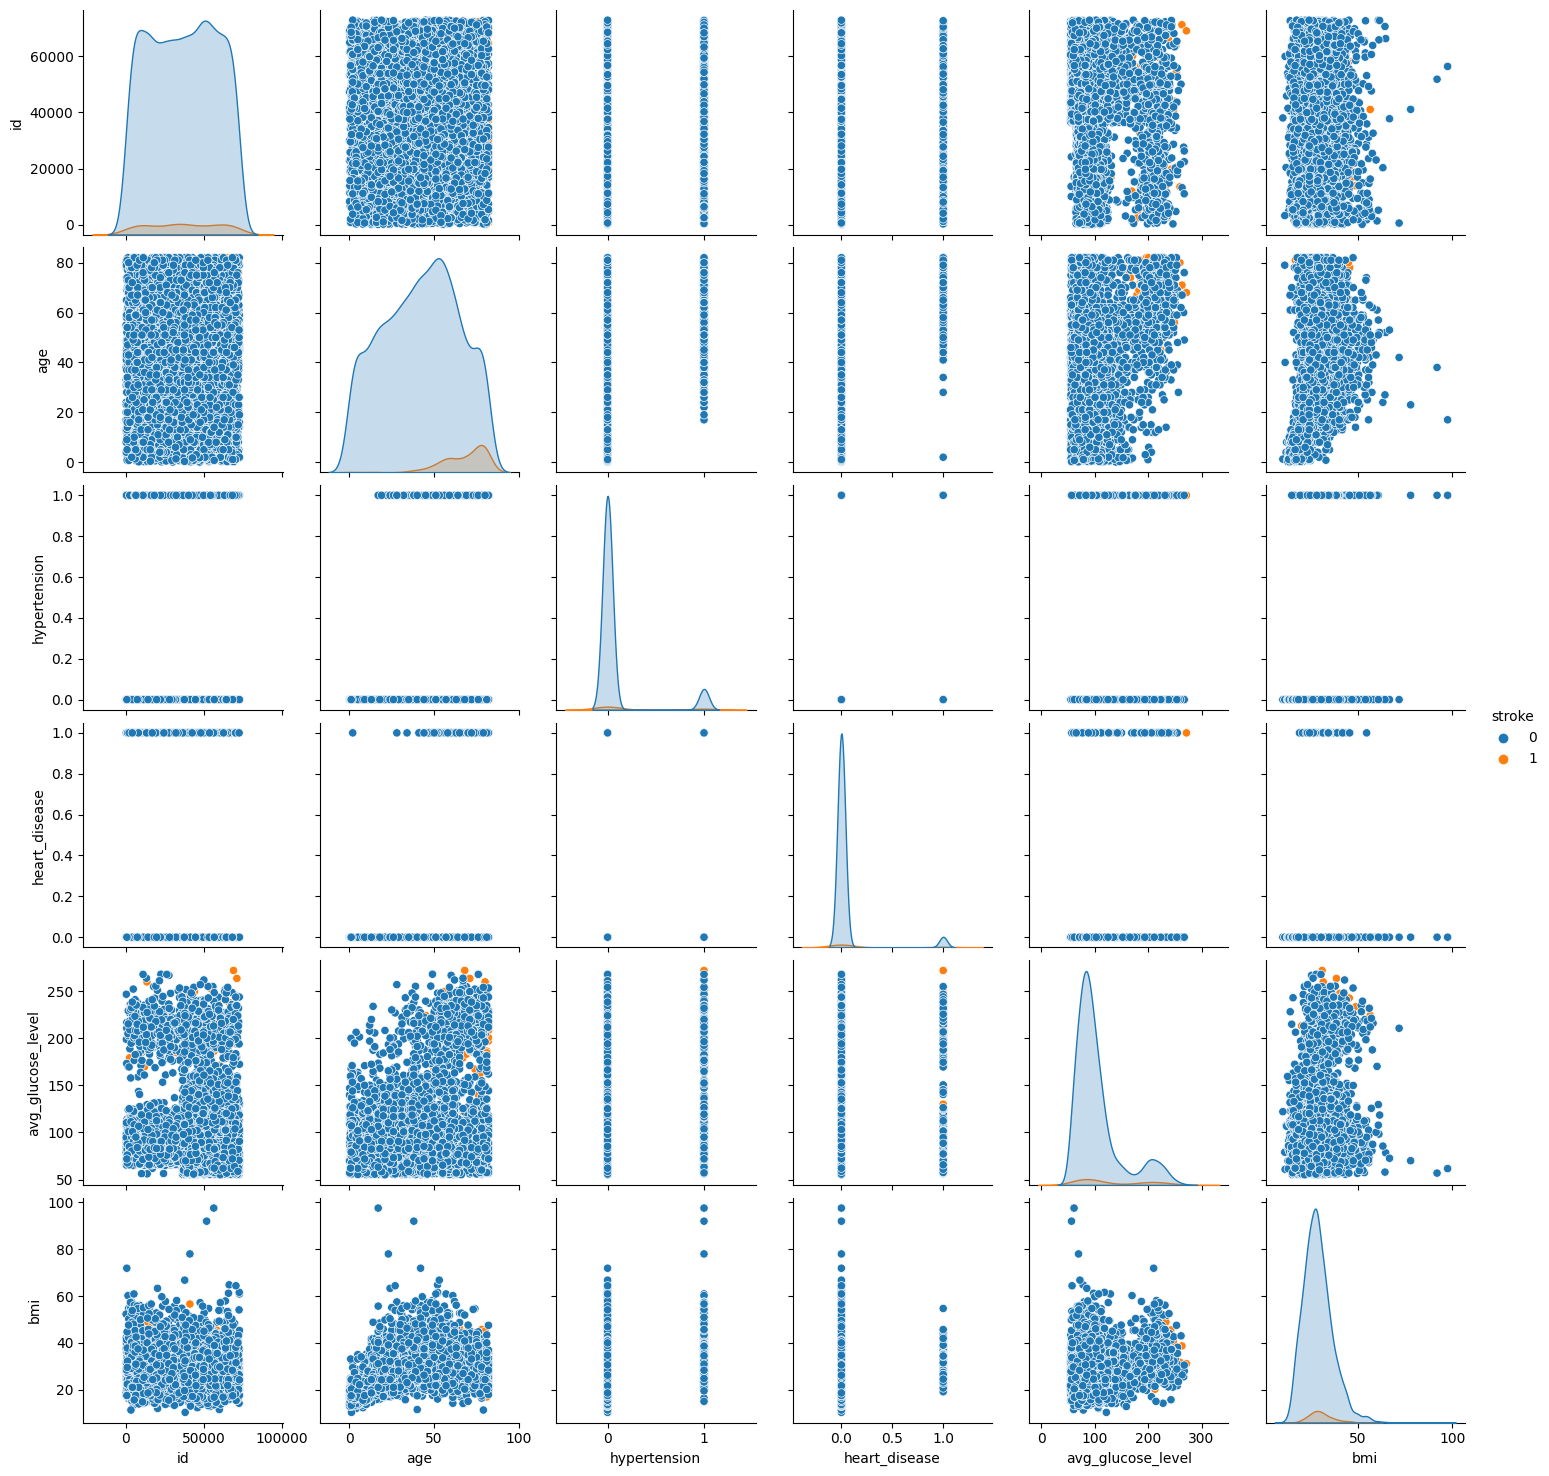

In [16]:
sns.pairplot(df, hue='stroke');

In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df_le = df.copy()

df_le['gender'] = le.fit_transform(df_le['gender'])
df_le['work_type'] = le.fit_transform(df_le['work_type'])
df_le['ever_married'] = le.fit_transform(df_le['ever_married'])
df_le['Residence_type'] = le.fit_transform(df_le['Residence_type'])
df_le['smoking_status'] = le.fit_transform(df_le['smoking_status'])

df_le.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,51676,0,61.0,0,0,1,3,0,202.21,NaN,2,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,2,1


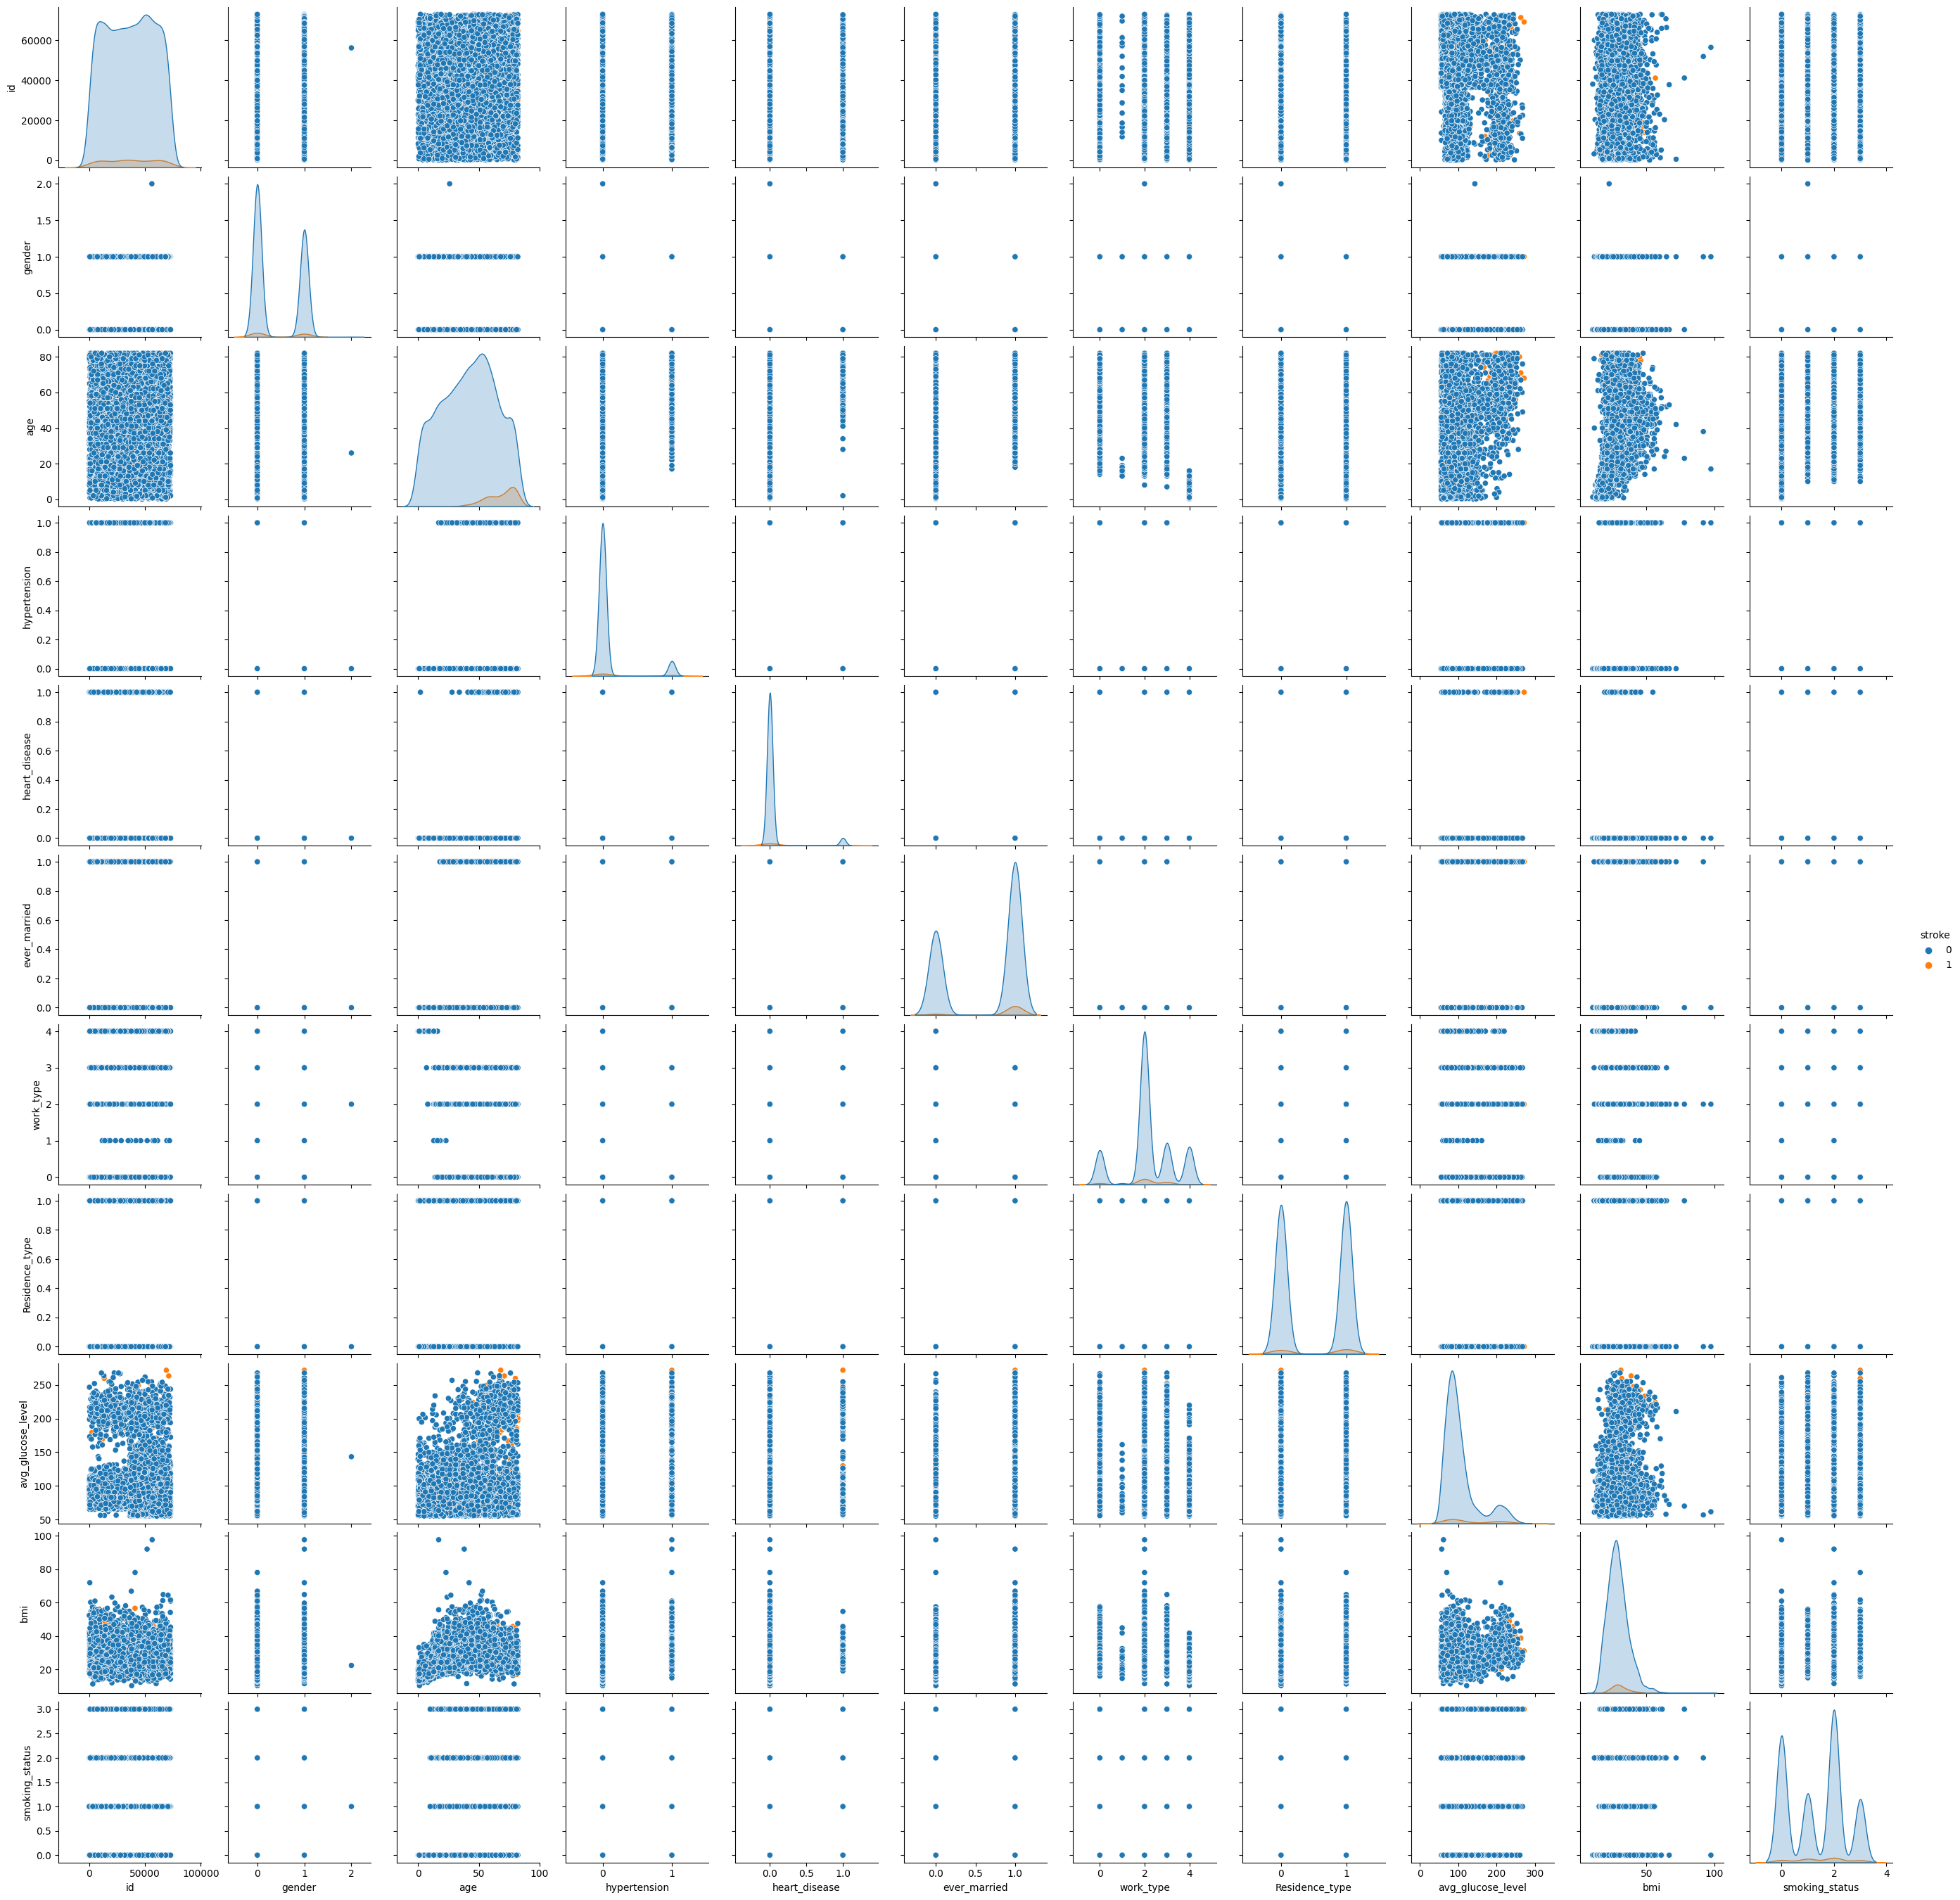

In [18]:
sns.pairplot(df_le, hue='stroke');

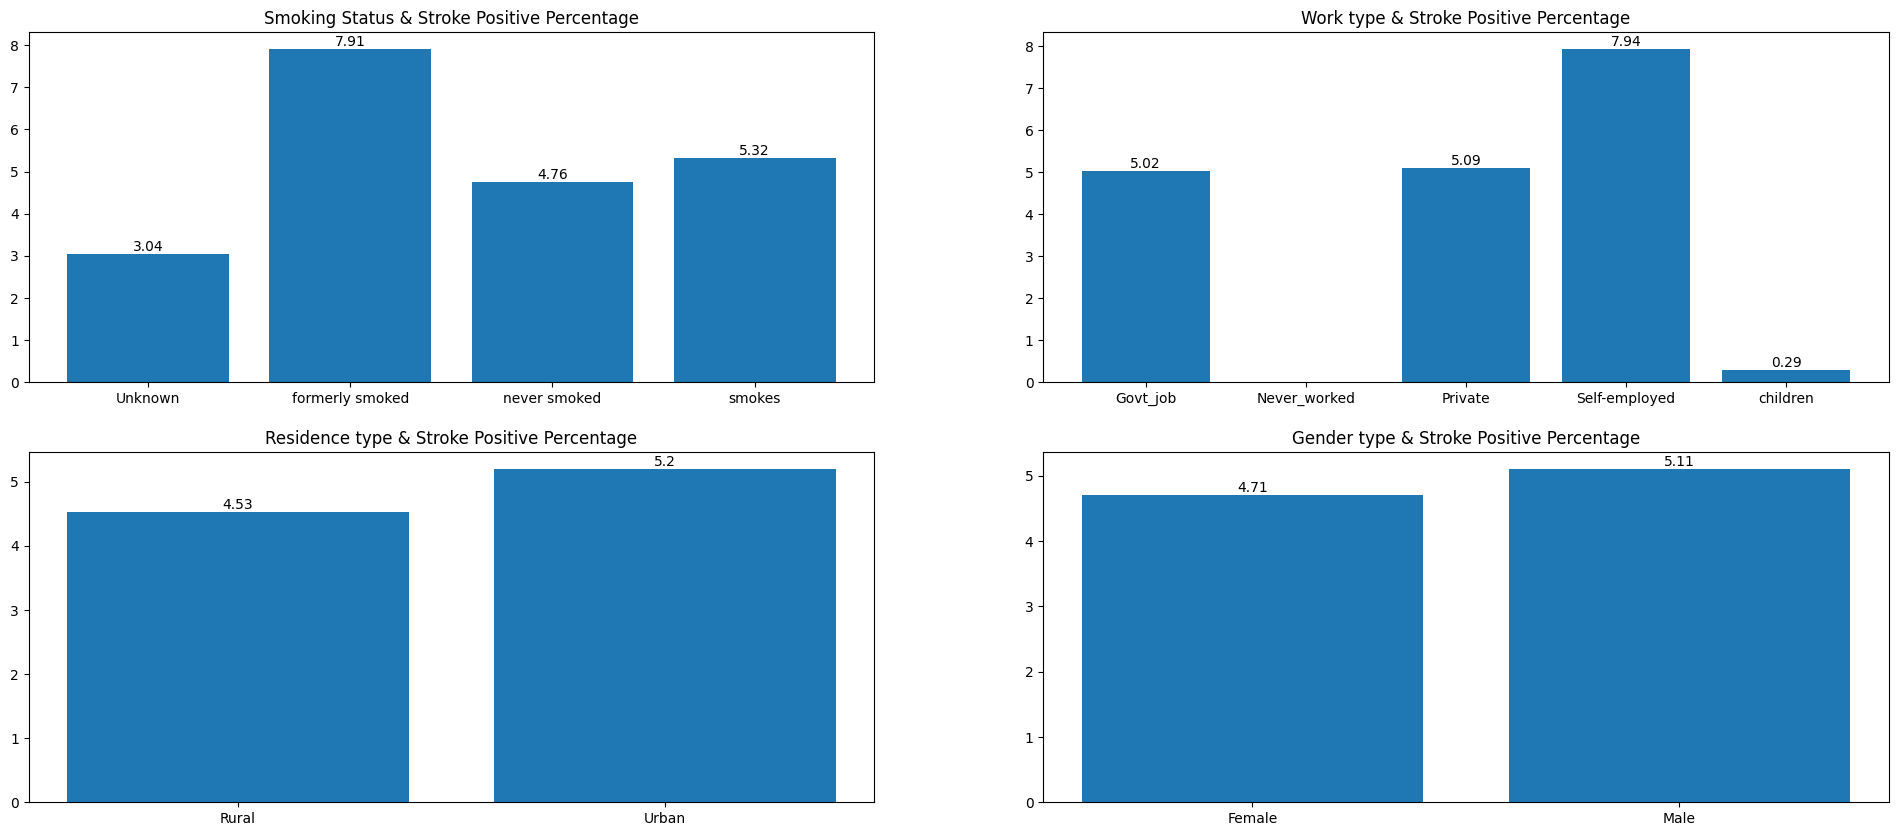

In [19]:
df_smoke = df[['smoking_status','stroke']]
smoke_category_counts = df_smoke.groupby('smoking_status')['stroke'].value_counts().unstack().reset_index()
smoke_category_counts['percentage'] = (smoke_category_counts.iloc[:,2] / (smoke_category_counts.iloc[:,1] +smoke_category_counts.iloc[:,2])) * 100

plt.figure(figsize=[24,10])

plt.subplot(2, 2, 1)
plt.title('Smoking Status & Stroke Positive Percentage')
plt.bar(smoke_category_counts['smoking_status'],smoke_category_counts['percentage'])
for i, value in enumerate(smoke_category_counts['percentage']):
    plt.text(i, value + 0, str(round(value,2)), ha='center', va='bottom')
    
# --------------------------------------------------------------------------------------------------------------------------------------------------------------
df_work_type = df[['work_type','stroke']]
work_type_counts = df_work_type.groupby('work_type')['stroke'].value_counts().unstack().reset_index()
work_type_counts['percentage'] = (work_type_counts.iloc[:,2] / (work_type_counts.iloc[:,1] + work_type_counts.iloc[:,2])) * 100

plt.subplot(2, 2, 2)
plt.title('Work type & Stroke Positive Percentage')
plt.bar(work_type_counts['work_type'],work_type_counts['percentage'])
for i, value in enumerate(work_type_counts['percentage']):
    plt.text(i, value + 0, str(round(value,2)), ha='center', va='bottom')

# --------------------------------------------------------------------------------------------------------------------------------------------------------------
df_residence_type = df[['Residence_type','stroke']]
residence_type_counts = df_residence_type.groupby('Residence_type')['stroke'].value_counts().unstack().reset_index()
residence_type_counts['percentage'] = (residence_type_counts.iloc[:,2] / (residence_type_counts.iloc[:,1] + residence_type_counts.iloc[:,2])) * 100

plt.subplot(2, 2, 3)
plt.title('Residence type & Stroke Positive Percentage')
plt.bar(residence_type_counts['Residence_type'],residence_type_counts['percentage'])
for i, value in enumerate(residence_type_counts['percentage']):
    plt.text(i, value + 0, str(round(value,2)), ha='center', va='bottom')
    
# --------------------------------------------------------------------------------------------------------------------------------------------------------------
df_gender_type = df[['gender','stroke']]
gender_type_counts = df_gender_type.groupby('gender')['stroke'].value_counts().unstack().reset_index()
gender_type_counts['percentage'] = (gender_type_counts .iloc[:,2] / (gender_type_counts .iloc[:,1] + gender_type_counts .iloc[:,2])) * 100

plt.subplot(2, 2, 4)
plt.title('Gender type & Stroke Positive Percentage')
plt.bar(gender_type_counts['gender'],gender_type_counts['percentage'])
for i, value in enumerate(gender_type_counts['percentage']):
    plt.text(i, value + 0, str(round(value,2)), ha='center', va='bottom')

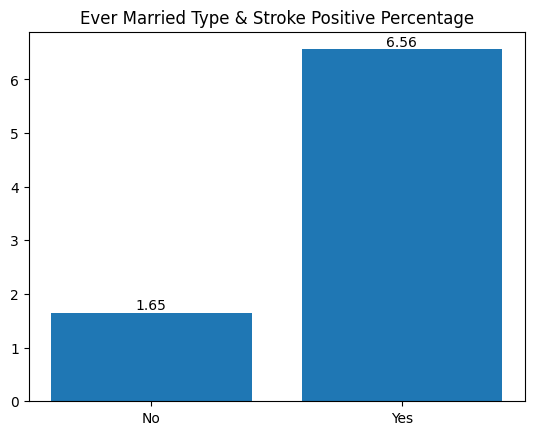

In [20]:
df_ever_married = df[['ever_married','stroke']]
ever_married_type_counts = df_ever_married.groupby('ever_married',)['stroke'].value_counts().unstack().reset_index()
ever_married_type_counts['percentage'] = (ever_married_type_counts .iloc[:,2] / (ever_married_type_counts .iloc[:,1] + ever_married_type_counts .iloc[:,2])) * 100

plt.title('Ever Married Type & Stroke Positive Percentage')
plt.bar(ever_married_type_counts['ever_married'],ever_married_type_counts['percentage'])
for i, value in enumerate(ever_married_type_counts['percentage']):
    plt.text(i, value + 0, str(round(value,2)), ha='center', va='bottom')

In [21]:
# GRAFIGE TEKRAR BAKILACAK.  

df_marry_gender = df[['ever_married','stroke','gender']]
marry_gender_type_counts = df_marry_gender.groupby('gender')[['ever_married','stroke']].value_counts().unstack().reset_index()
marry_gender_type_counts['percentage'] = (marry_gender_type_counts .iloc[:,3] / (marry_gender_type_counts .iloc[:,3] + marry_gender_type_counts .iloc[:,2])) * 100
marry_gender_type_counts


stroke,gender,ever_married,0,1,percentage
0,Female,No,972.0,21.0,2.114804
1,Female,Yes,1881.0,120.0,5.997001
2,Male,No,755.0,8.0,1.048493
3,Male,Yes,1252.0,100.0,7.396450
4,Other,No,1.0,NaN,NaN


In [22]:
"""
plt.figure(figsize=[18,10])
# Plotting a bar chart
plt.subplot(2, 2, 1)
plt.title('Histogram of Average Glucose Level')
sns.histplot(df.avg_glucose_level, bins=25,color = 'cornflowerblue')

plt.subplot(2, 2, 2)
plt.title('Histogram of Log-Average Glucose Level')
sns.histplot(np.log(df.avg_glucose_level), bins=25,color = 'royalblue')

plt.subplot(2, 2, 3)
plt.title('Histogram of BMI')
sns.histplot(df.bmi, bins=25,color = 'moccasin')

plt.subplot(2, 2, 4)
plt.title('Histogram of Log-BMI')
sns.histplot(np.log(df.bmi), bins=25,color = 'gold');

"""

"\nplt.figure(figsize=[18,10])\n# Plotting a bar chart\nplt.subplot(2, 2, 1)\nplt.title('Histogram of Average Glucose Level')\nsns.histplot(df.avg_glucose_level, bins=25,color = 'cornflowerblue')\n\nplt.subplot(2, 2, 2)\nplt.title('Histogram of Log-Average Glucose Level')\nsns.histplot(np.log(df.avg_glucose_level), bins=25,color = 'royalblue')\n\nplt.subplot(2, 2, 3)\nplt.title('Histogram of BMI')\nsns.histplot(df.bmi, bins=25,color = 'moccasin')\n\nplt.subplot(2, 2, 4)\nplt.title('Histogram of Log-BMI')\nsns.histplot(np.log(df.bmi), bins=25,color = 'gold');\n\n"

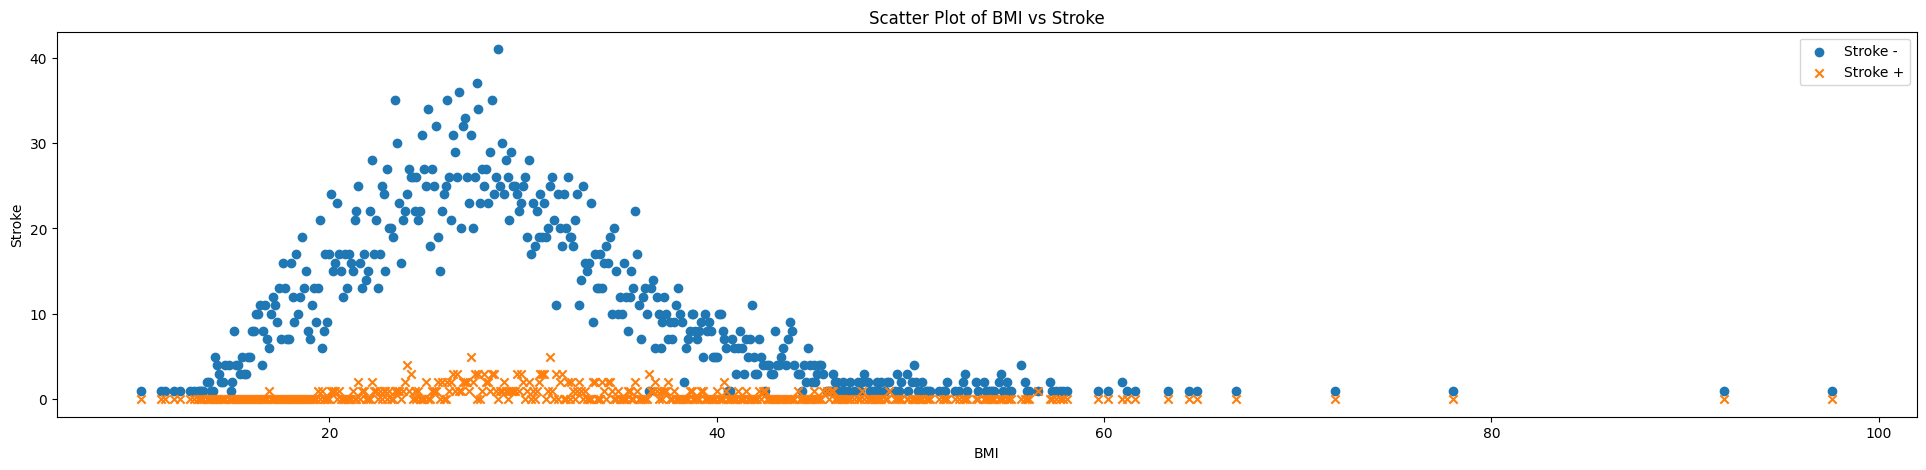

In [23]:
filtered_total = df.groupby('bmi').stroke.count() # Toplam Kişi Sayısı
filtered_group = df[df.stroke == 0].groupby('bmi').stroke.count() # Yaşayan Kişi Sayısı

bmi_df = pd.concat([filtered_group, filtered_total-filtered_group], axis=1, keys=['Stroke_Neg', 'Stroke_Pos'])
bmi_df = bmi_df.reset_index()

plt.figure(figsize=[24,5])
plt.scatter(x=bmi_df['bmi'], y=bmi_df['Stroke_Neg'], label='Stroke -', marker='o')
plt.scatter(x=bmi_df['bmi'], y=bmi_df['Stroke_Pos'], label='Stroke +', marker='x')
# Add labels and title
plt.xlabel('BMI')
plt.ylabel('Stroke')
plt.title('Scatter Plot of BMI vs Stroke')
plt.legend()

# Show the plot
plt.show()

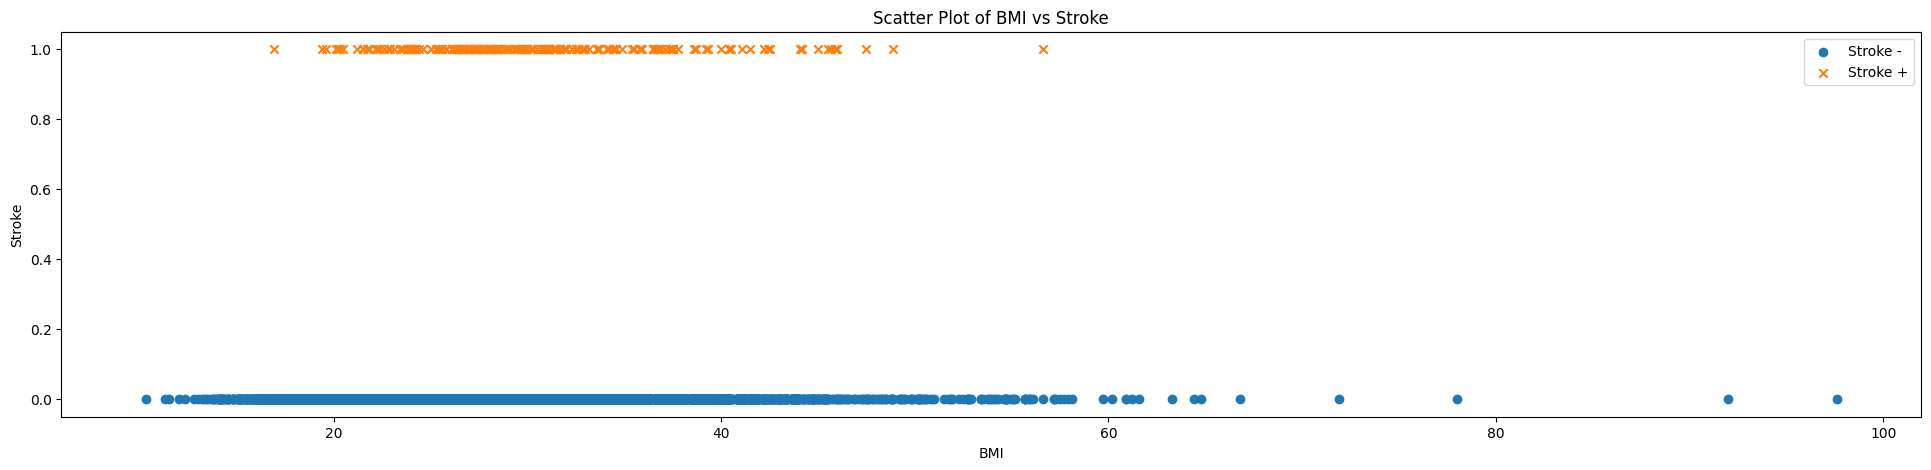

In [24]:
df_stroke_pos = df[df['stroke'] == 1]
df_stroke_neg = df[df['stroke'] == 0]

plt.figure(figsize=[24,5])
plt.scatter(x=df_stroke_neg['bmi'], y=df_stroke_neg['stroke'], label='Stroke -', marker='o')
plt.scatter(x=df_stroke_pos['bmi'], y=df_stroke_pos['stroke'],label='Stroke +', marker='x')
# Add labels and title
plt.xlabel('BMI')
plt.ylabel('Stroke')
plt.title('Scatter Plot of BMI vs Stroke')
plt.legend();

# 3. Feature Engineering

We tried to make a conculusion based on the dataset but the sample quatity of the stroke positive is too low. It is only 4.9 % stroke positive. Therefore, we need to use oversampling techniques to make a more accurate predictions. 

**Comments About Dataset** 

* 4.9 % of the data has stroke value. We might need to user Oversampling techniques will help us to get a better results.
* Undersampling will not be applied to this dataset due to low quantity data. 

* Id column is an unique for each of the row. Therefore, it is likely to remove and not use it in our analysis.

* Gender columns likely to have 2 unique value but we have 3 values. Only one column has other value.
* Also, gender is not a distinct column according to EDA. Therefore needs to be deleted. 

* Location of the living area doesn't make that much of a difference. Rural or Urban not so different so can be deleted.

* 1544 rows don't have information about the somking status which is unknown. (%30 of total dataset.)
* We possibly fullfill those calues by not chancing the data histogram. 

* 201 rows don't have BMI value which is roughly %4  of our dataset. We need to find a solution for that. 
* BMI index seems wrong. Today max BMI valu for adults around 50 or 60 . This value should be used as it is bacause it gives us an idcation of the height to wieght ratio and also different for kids and adults. 
* BMI column will be deleted not direclt link with stroke.

* Positive values defined as 1 in our dataset. Therefore, ever_married column can be trasnformed to 1s and 0s to make it easier.

* Work_type column defines the type of work and children might be irrelevant tod this column and also we have this information in the age column. Therefore, we can convert chidlren to never_worked to only have 3 class. 
* Employement can be an indicator for a stress level indicator for ou dataset. 
       Selfemployed is the - high stress
       Goverment employees - medium stress
       Children/ never worked - low stress

* Ever_maried column is one of the critical criteria for the model.


In [25]:
df.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


In [26]:
def stress_level(work):
    if 'Self-employed' in work:
        return 'High'
    elif 'Govt_job' in work or 'Private' in work:
        return 'Medium'
    elif 'children' in work or 'Never_worked' in work:
        return 'Low'

In [27]:
def diabates(avg_glucose_level):
    if avg_glucose_level > 126 :
        return 'diabetes'
    elif avg_glucose_level >= 100  and avg_glucose_level <= 126 :
        return 'prediabetes'
    elif  avg_glucose_level < 100 :
        return 'normal'

In [28]:
# In the dataset , positive values stated as 1 and negatives as 0. Same rule applied to ever_maried column. ever_married_num column is created and ever_maried is dropped.  
df['ever_married'] = df['ever_married'].apply(lambda x: 1 if x == 'Yes' else 0)

# Filling the BMI values in the same disturibiton 
for dataset in df:
    mean = df["bmi"].mean()
    std = df["bmi"].std()
    is_null = df["bmi"].isnull().sum()
    # Standart sapmayı kullanarak rastgele integer değerler oluşturma
    rand_bmi = np.random.randint(mean - std, mean + std, size = is_null)
    # Boş değerlerimizi oluşturduğumuz rastgele integer değerlerle doldurma
    bmi_slice = df["bmi"].copy()
    bmi_slice[np.isnan(bmi_slice)] = rand_bmi
    df["bmi"] = bmi_slice
    df["bmi"] = df['bmi'].astype(int)
df["bmi"].isnull().sum()


# Additional column for stress level 
df['stress_lvl'] = df['work_type'].apply(stress_level)
stress_lvl_num = {'High':2, 'Medium':1, 'Low':0}
df['stress_lvl']= df['stress_lvl'].map(stress_lvl_num)
df['diabetes'] = df['avg_glucose_level'].apply(diabates)


#Id column has unique values for each row. Therefore, it has been deleted. 

df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,stress_lvl,diabetes
0,9046,Male,67.0,0,1,1,Private,Urban,228.69,36,formerly smoked,1,1,diabetes
1,51676,Female,61.0,0,0,1,Self-employed,Rural,202.21,34,never smoked,1,2,diabetes
2,31112,Male,80.0,0,1,1,Private,Rural,105.92,32,never smoked,1,1,prediabetes
3,60182,Female,49.0,0,0,1,Private,Urban,171.23,34,smokes,1,1,diabetes
4,1665,Female,79.0,1,0,1,Self-employed,Rural,174.12,24,never smoked,1,2,diabetes


In [29]:
df_1 = df.drop(columns = ['id','gender','Residence_type','bmi'])
df_1.head()

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,smoking_status,stroke,stress_lvl,diabetes
0,67.0,0,1,1,Private,228.69,formerly smoked,1,1,diabetes
1,61.0,0,0,1,Self-employed,202.21,never smoked,1,2,diabetes
2,80.0,0,1,1,Private,105.92,never smoked,1,1,prediabetes
3,49.0,0,0,1,Private,171.23,smokes,1,1,diabetes
4,79.0,1,0,1,Self-employed,174.12,never smoked,1,2,diabetes


In [30]:
df_1['work_type'] = df_1['work_type'].apply(lambda x: 'Never_worked' if x == 'children'else x)

In [31]:
df_1.head(10)

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,smoking_status,stroke,stress_lvl,diabetes
0,67.0,0,1,1,Private,228.69,formerly smoked,1,1,diabetes
1,61.0,0,0,1,Self-employed,202.21,never smoked,1,2,diabetes
2,80.0,0,1,1,Private,105.92,never smoked,1,1,prediabetes
3,49.0,0,0,1,Private,171.23,smokes,1,1,diabetes
4,79.0,1,0,1,Self-employed,174.12,never smoked,1,2,diabetes
5,81.0,0,0,1,Private,186.21,formerly smoked,1,1,diabetes
6,74.0,1,1,1,Private,70.09,never smoked,1,1,normal
7,69.0,0,0,0,Private,94.39,never smoked,1,1,normal
8,59.0,0,0,1,Private,76.15,Unknown,1,1,normal
9,78.0,0,0,1,Private,58.57,Unknown,1,1,normal


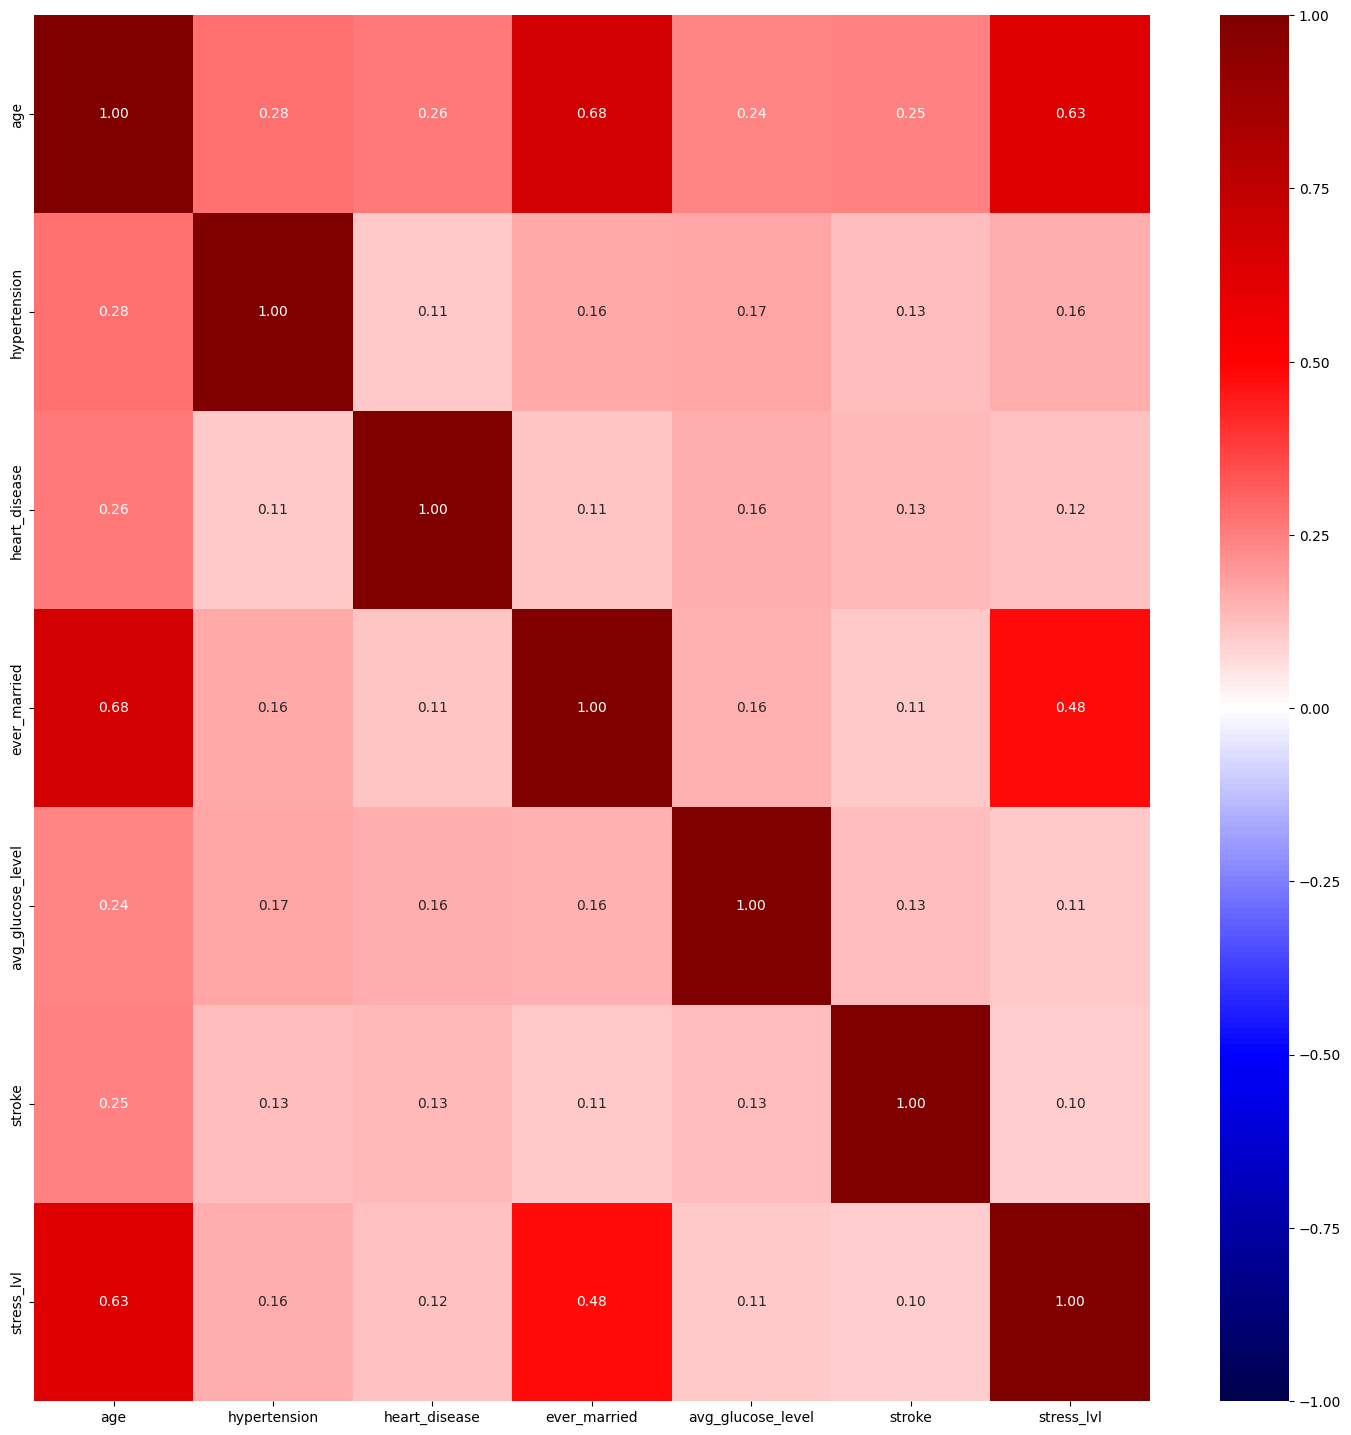

In [34]:
df_1_corr = df_1.drop(columns = ['work_type','smoking_status','diabetes'])
plt.figure(figsize=[18,18])
sns.heatmap(df_1_corr .corr(), cmap="seismic", annot=True, fmt='.2f', vmin=-1, vmax=1);

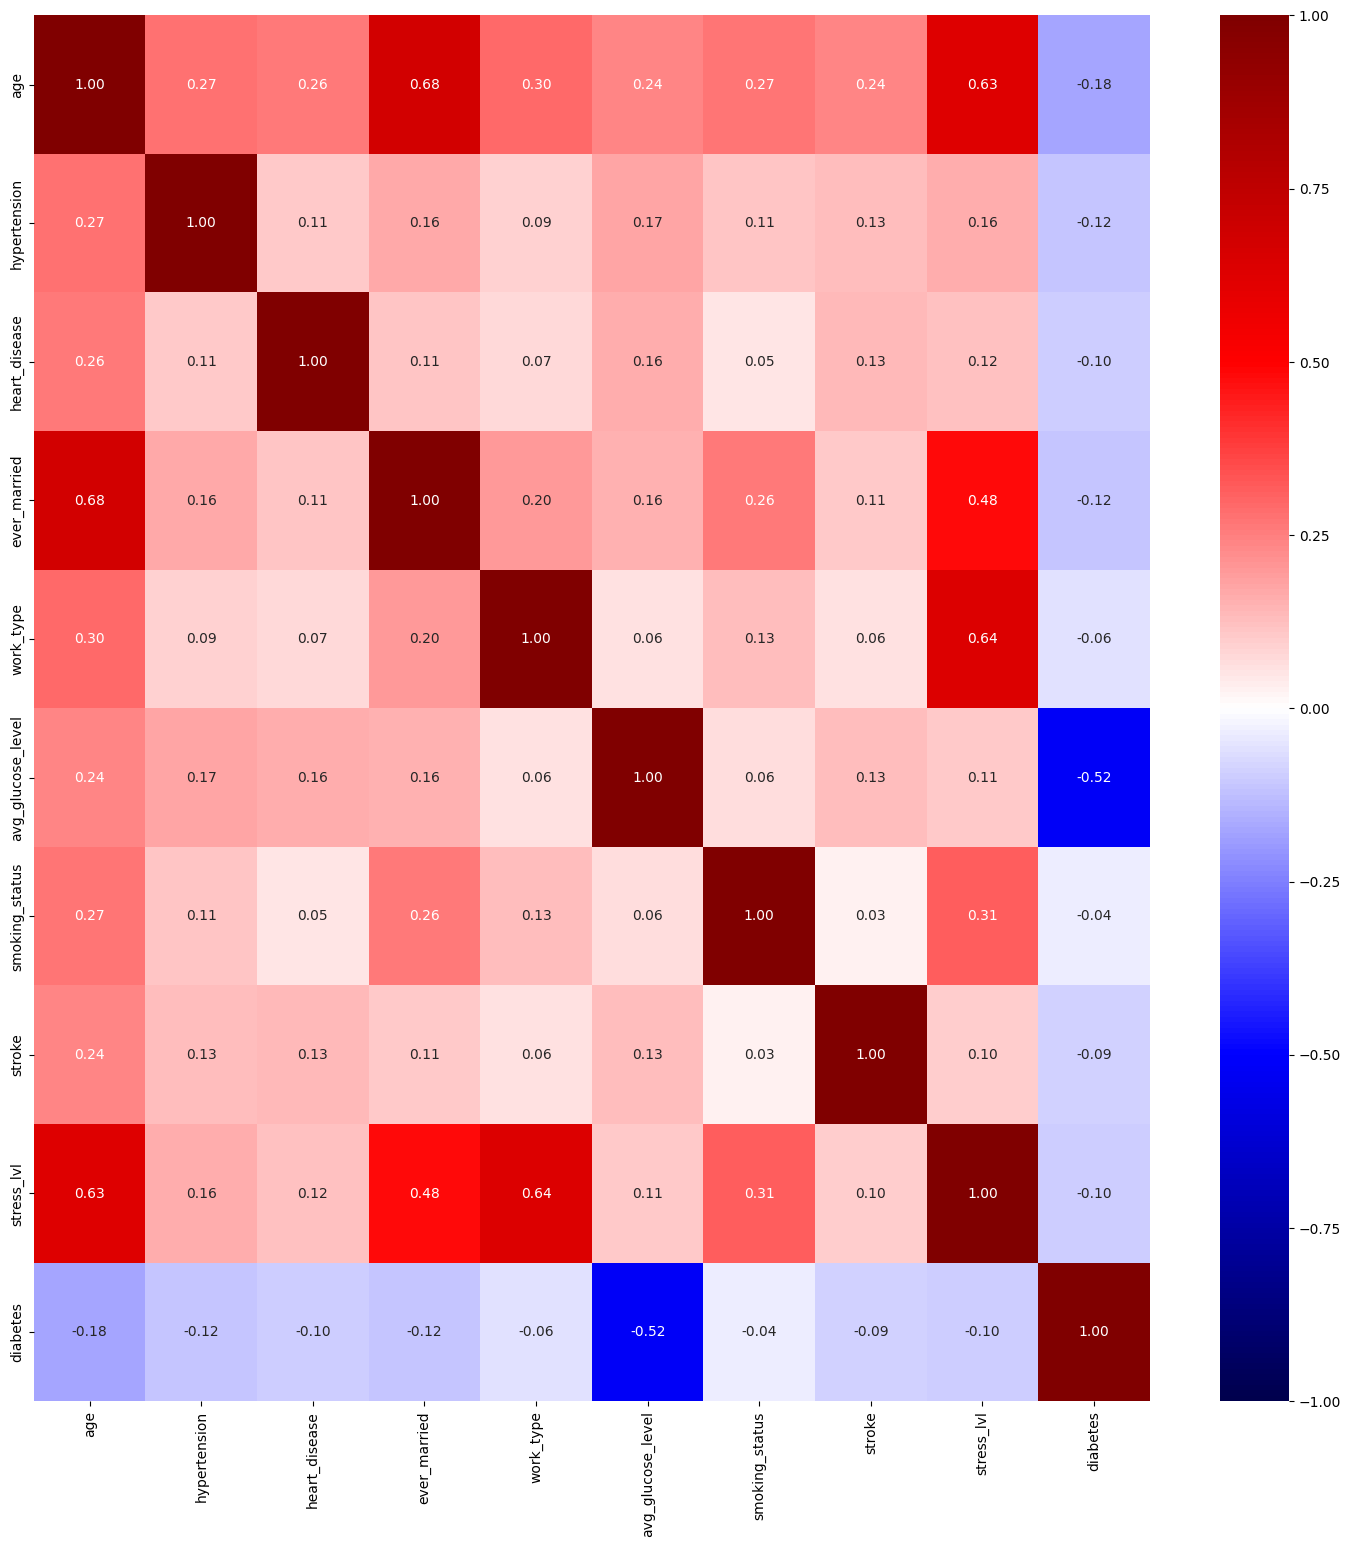

In [61]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

df_1_le_corr = df_1.copy()

df_1_le_corr['work_type'] = le.fit_transform(df_1_le_corr['work_type'])
df_1_le_corr['smoking_status'] = le.fit_transform(df_1_le_corr['smoking_status'])
df_1_le_corr['diabetes'] = le.fit_transform(df_1_le_corr['diabetes'])
df_1_le_corr['age'] = le.fit_transform(df_1_le_corr['age'])

df_1_le_corr.head()

plt.figure(figsize=[18,18])
sns.heatmap(df_1_le_corr .corr(), cmap="seismic", annot=True, fmt='.2f', vmin=-1, vmax=1);

In [36]:
df_1.head(10)

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,smoking_status,stroke,stress_lvl,diabetes
0,67.0,0,1,1,Private,228.69,formerly smoked,1,1,diabetes
1,61.0,0,0,1,Self-employed,202.21,never smoked,1,2,diabetes
2,80.0,0,1,1,Private,105.92,never smoked,1,1,prediabetes
3,49.0,0,0,1,Private,171.23,smokes,1,1,diabetes
4,79.0,1,0,1,Self-employed,174.12,never smoked,1,2,diabetes
5,81.0,0,0,1,Private,186.21,formerly smoked,1,1,diabetes
6,74.0,1,1,1,Private,70.09,never smoked,1,1,normal
7,69.0,0,0,0,Private,94.39,never smoked,1,1,normal
8,59.0,0,0,1,Private,76.15,Unknown,1,1,normal
9,78.0,0,0,1,Private,58.57,Unknown,1,1,normal


In [39]:
df_1_dummies = pd.get_dummies(df_1[['work_type','smoking_status','diabetes']], drop_first=True)
df_2 = pd.concat([df_1,df_1_dummies],axis = 1)
df_2.replace({True: 1, False: 0}, inplace=True)
df_2.drop(columns = ['work_type','smoking_status','diabetes'],inplace = True)
df_2.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,stroke,stress_lvl,work_type_Never_worked,work_type_Private,work_type_Self-employed,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,diabetes_normal,diabetes_prediabetes
0,67.0,0,1,1,228.69,1,1,0,1,0,1,0,0,0,0
1,61.0,0,0,1,202.21,1,2,0,0,1,0,1,0,0,0
2,80.0,0,1,1,105.92,1,1,0,1,0,0,1,0,0,1
3,49.0,0,0,1,171.23,1,1,0,1,0,0,0,1,0,0
4,79.0,1,0,1,174.12,1,2,0,0,1,0,1,0,0,0


# 4. Model

Before the model creation,oversampling techniques are need to be applied due to the stroke positive quantity. It is only 4.9 % stroke positive. 
We only have 5k rows thus we will not use understampling techniques.
Also, will only apply to train df not test.

In [40]:
# Seperating test and train dataframe from out dataframe. 20 % will be test and 80 train. 
X = df_2.drop(columns = ['stroke'])
y = df_2.stroke
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# stratify=y parametresi veri setini bölme aşamasında train ve testteki label dağılımının dengeli olacağını söyler

In [41]:
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(model, threshold=0.5): # Ön tanımlı threshold değeri
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=100)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Stroke -', 'Stroke +'],
           yticklabels=['Stroke -', 'Stroke +']);
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

In [42]:
rf = RandomForestClassifier()
acc_rf = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')

dt = DecisionTreeClassifier() 
acc_dt = cross_val_score(dt, X_train, y_train, cv=5, scoring='accuracy')

xgboost = XGBClassifier()
acc_xgboost = cross_val_score(xgboost, X_train, y_train, cv=5, scoring='accuracy')

from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler()
X_train_scaled = std_scale.fit_transform(X_train)
X_test_scaled = std_scale.transform(X_test)

logreg = LogisticRegression(solver='liblinear')
acc_logreg = cross_val_score(logreg, X_train_scaled, y_train, cv=5, scoring='accuracy')

knn = KNeighborsClassifier()
acc_knn = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')

perceptron = Perceptron()
acc_perc = cross_val_score(perceptron, X_train_scaled, y_train, cv=5, scoring='accuracy')

svc = SVC()
acc_svc = cross_val_score(svc, X_train_scaled, y_train, cv=5, scoring='accuracy')

results = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree', 'XGBoost',
              'Logistic Regression', 'KNN', 'Perceptron', 'SVC'],
    'Cross Validated Score (Mean)': [acc_rf.mean(), acc_dt.mean(), acc_xgboost.mean(), acc_logreg.mean(),
                                     acc_knn.mean(), acc_perc.mean(), acc_svc.mean()],
    'Cross Validated Score (Std)': [acc_rf.std(), acc_dt.std(), acc_xgboost.std(), acc_logreg.std(),
                                    acc_knn.std(), acc_perc.std(), acc_svc.std()]})

result_df = results.sort_values(by='Cross Validated Score (Mean)', ascending=False)
result_df = result_df.set_index('Model')
result_df['Cross Validated Score (Mean)'] = (result_df['Cross Validated Score (Mean)']*100).round(2)
result_df['Cross Validated Score (Std)'] = (result_df['Cross Validated Score (Std)']*100).round(2)
result_df

,Cross Validated Score (Mean),Cross Validated Score (Std)
Model,,
SVC,95.14,0.05
Logistic Regression,95.11,0.09
Perceptron,94.69,0.91
Random Forest,94.44,0.10
KNN,94.38,0.31
XGBoost,93.79,0.36
Decision Tree,91.47,0.99


In [43]:
svc = SVC()
svc.fit(X_train_scaled, y_train)
svc.score(X_test_scaled, y_test)

0.9510763209393346

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


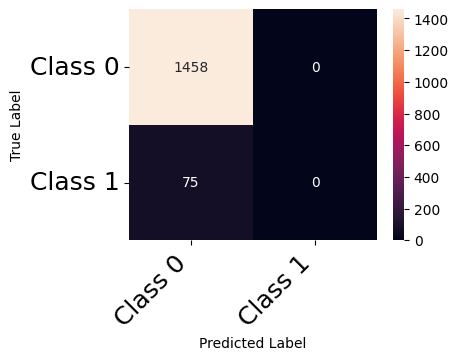

In [44]:
print_confusion_matrix(confusion_matrix(y_test, svc.predict(X_test)), ['Class 0', 'Class 1'])

In [ ]:
"""
# Seperating test and train dataframe from out dataframe. 20 % will be test and 80 train. 
X_le = df_le.drop(columns = ['stroke'])
y_le = df_le.stroke
X_train_le, X_test_le, y_train_le, y_test_le = train_test_split(X_le, y_le, test_size=0.3, random_state=42, stratify=y)
# stratify=y parametresi veri setini bölme aşamasında train ve testteki label dağılımının dengeli olacağını söyler

rf = RandomForestClassifier()
acc_rf = cross_val_score(rf, X_train_le, y_train_le, cv=5, scoring='accuracy')

dt = DecisionTreeClassifier() 
acc_dt = cross_val_score(dt, X_train_le, y_train_le, cv=5, scoring='accuracy')

xgboost = XGBClassifier()
acc_xgboost = cross_val_score(xgboost, X_train_le, y_train_le, cv=5, scoring='accuracy')

from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler()
X_train_le_scaled = std_scale.fit_transform(X_train_le)
X_test_le_scaled = std_scale.transform(X_test_le)

logreg = LogisticRegression(solver='liblinear')
acc_logreg = cross_val_score(logreg, X_train_le_scaled, y_train_le, cv=5, scoring='accuracy')

knn = KNeighborsClassifier()
acc_knn = cross_val_score(knn, X_train_le_scaled, y_train_le, cv=5, scoring='accuracy')

perceptron = Perceptron()
acc_perc = cross_val_score(perceptron, X_train_le_scaled, y_train_le, cv=5, scoring='accuracy')

svc = SVC()
acc_svc = cross_val_score(svc, X_train_le_scaled, y_train_le, cv=5, scoring='accuracy')

results = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree', 'XGBoost',
              'Logistic Regression', 'KNN', 'Perceptron', 'SVC'],
    'Cross Validated Score (Mean)': [acc_rf.mean(), acc_dt.mean(), acc_xgboost.mean(), acc_logreg.mean(),
                                     acc_knn.mean(), acc_perc.mean(), acc_svc.mean()],
    'Cross Validated Score (Std)': [acc_rf.std(), acc_dt.std(), acc_xgboost.std(), acc_logreg.std(),
                                    acc_knn.std(), acc_perc.std(), acc_svc.std()]})

result_df = results.sort_values(by='Cross Validated Score (Mean)', ascending=False)
result_df = result_df.set_index('Model')
result_df['Cross Validated Score (Mean)'] = (result_df['Cross Validated Score (Mean)']*100).round(2)
result_df['Cross Validated Score (Std)'] = (result_df['Cross Validated Score (Std)']*100).round(2)
result_df
"""

In [47]:
# A - Random Oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

#-------------------------------------------------------------------------------------------------------------------
rf = RandomForestClassifier()
acc_rf = cross_val_score(rf, X_resampled, y_resampled, cv=5, scoring='accuracy',)

#-------------------------------------------------------------------------------------------------------------------
dt = DecisionTreeClassifier() 
acc_dt = cross_val_score(dt, X_resampled, y_resampled, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
xgboost = XGBClassifier()
acc_xgboost = cross_val_score(xgboost, X_resampled, y_resampled, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------

from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler()
X_train_resampled_scaled = std_scale.fit_transform(X_resampled)
X_test_resampled_scaled = std_scale.transform(X_test)

logreg = LogisticRegression(solver='liblinear')
acc_logreg = cross_val_score(logreg, X_train_resampled_scaled, y_resampled, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
knn = KNeighborsClassifier()
acc_knn = cross_val_score(knn, X_train_resampled_scaled, y_resampled, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
perceptron = Perceptron()
acc_perc = cross_val_score(perceptron, X_train_resampled_scaled, y_resampled, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
svc = SVC()
acc_svc = cross_val_score(svc, X_train_resampled_scaled, y_resampled, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
results = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree', 'XGBoost',
              'Logistic Regression', 'KNN', 'Perceptron', 'SVC'],
    'Cross Validated Score (Mean)': [acc_rf.mean(), acc_dt.mean(), acc_xgboost.mean(), acc_logreg.mean(),
                                     acc_knn.mean(), acc_perc.mean(), acc_svc.mean()],
    'Cross Validated Score (Std)': [acc_rf.std(), acc_dt.std(), acc_xgboost.std(), acc_logreg.std(),
                                    acc_knn.std(), acc_perc.std(), acc_svc.std()]})

result_df = results.sort_values(by='Cross Validated Score (Mean)', ascending=False)
result_df = result_df.set_index('Model')
result_df['Cross Validated Score (Mean)'] = (result_df['Cross Validated Score (Mean)']*100).round(2)
result_df['Cross Validated Score (Std)'] = (result_df['Cross Validated Score (Std)']*100).round(2)
result_df


,Cross Validated Score (Mean),Cross Validated Score (Std)
Model,,
Random Forest,98.28,0.50
Decision Tree,97.52,0.68
XGBoost,96.94,0.67
KNN,93.15,0.56
SVC,83.56,0.80
Logistic Regression,78.33,0.77
Perceptron,67.29,3.59


In [51]:
rf = RandomForestClassifier()
rf.fit(X_resampled, y_resampled)
rf.score(X_test_scaled, y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.9510763209393346

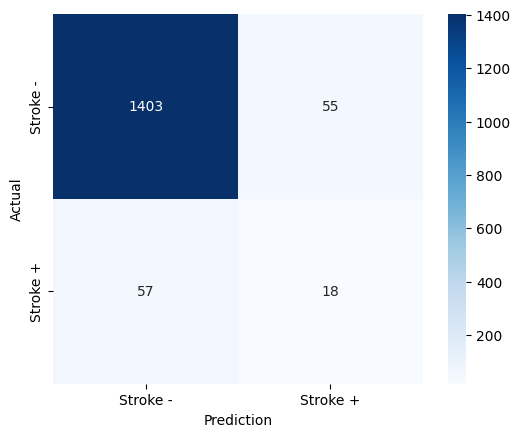

In [52]:
make_confusion_matrix(rf)

In [53]:
knn = KNeighborsClassifier()

knn.fit(X_train_resampled_scaled, y_resampled)
knn.score(X_test_resampled_scaled, y_test)

0.8512720156555773

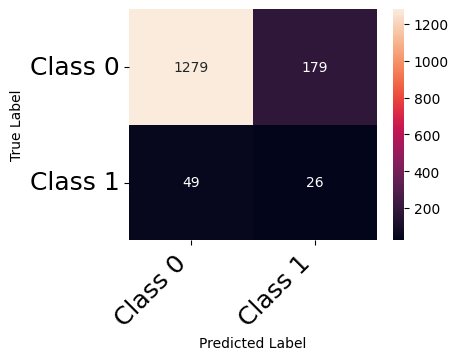

In [56]:
print_confusion_matrix(confusion_matrix(y_test, knn.predict(X_test_resampled_scaled)), ['Class 0', 'Class 1'])

In [57]:
perceptron = Perceptron()
perceptron.fit(X_train_resampled_scaled, y_resampled)
perceptron.score(X_test_resampled_scaled, y_test)

0.6757990867579908

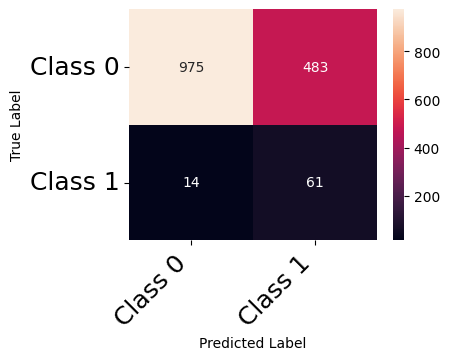

In [58]:
print_confusion_matrix(confusion_matrix(y_test, perceptron.predict(X_test_resampled_scaled)), ['Class 0', 'Class 1'])

In [59]:
evaluate_model(perceptron, X_test_resampled_scaled, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.676,0.669,0.986,0.797,0.741


In [60]:
evaluate_model(perceptron, X_test_resampled_scaled, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.676,0.813,0.112,0.197,0.741


In [48]:
# B - SMOTE (Synthetic Minority Oversampling Technique)
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE().fit_resample(X_train, y_train)

#-------------------------------------------------------------------------------------------------------------------
rf = RandomForestClassifier()
acc_rf = cross_val_score(rf, X_smoted, y_smoted, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
dt = DecisionTreeClassifier() 
acc_dt = cross_val_score(dt, X_smoted, y_smoted, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
xgboost = XGBClassifier()
acc_xgboost = cross_val_score(xgboost, X_smoted, y_smoted, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------

from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler()
X_train_smoted_scaled = std_scale.fit_transform(X_smoted)
X_test_smoted_scaled = std_scale.transform(X_test)

logreg = LogisticRegression(solver='liblinear')
acc_logreg = cross_val_score(logreg, X_train_smoted_scaled, y_smoted, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
knn = KNeighborsClassifier()
acc_knn = cross_val_score(knn, X_train_smoted_scaled, y_smoted, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
perceptron = Perceptron()
acc_perc = cross_val_score(perceptron, X_train_smoted_scaled, y_smoted, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
svc = SVC()
acc_svc = cross_val_score(svc, X_train_smoted_scaled, y_smoted, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
results = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree', 'XGBoost',
              'Logistic Regression', 'KNN', 'Perceptron', 'SVC'],
    'Cross Validated Score (Mean)': [acc_rf.mean(), acc_dt.mean(), acc_xgboost.mean(), acc_logreg.mean(),
                                     acc_knn.mean(), acc_perc.mean(), acc_svc.mean()],
    'Cross Validated Score (Std)': [acc_rf.std(), acc_dt.std(), acc_xgboost.std(), acc_logreg.std(),
                                    acc_knn.std(), acc_perc.std(), acc_svc.std()]})

result_df = results.sort_values(by='Cross Validated Score (Mean)', ascending=False)
result_df = result_df.set_index('Model')
result_df['Cross Validated Score (Mean)'] = (result_df['Cross Validated Score (Mean)']*100).round(2)
result_df['Cross Validated Score (Std)'] = (result_df['Cross Validated Score (Std)']*100).round(2)
result_df


,Cross Validated Score (Mean),Cross Validated Score (Std)
Model,,
XGBoost,94.49,2.65
Random Forest,94.09,2.48
Decision Tree,91.85,2.37
KNN,91.71,2.78
SVC,88.07,2.84
Logistic Regression,86.26,2.90
Perceptron,79.65,4.39


In [49]:
# C - ADASYN (Adaptive Synthetic Oversampling)
from imblearn.over_sampling import ADASYN
X_adasyn, y_adasyn = ADASYN().fit_resample(X_train, y_train)

#-------------------------------------------------------------------------------------------------------------------
rf = RandomForestClassifier()
acc_rf = cross_val_score(rf, X_adasyn, y_adasyn, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
dt = DecisionTreeClassifier() 
acc_dt = cross_val_score(dt, X_adasyn, y_adasyn, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
xgboost = XGBClassifier()
acc_xgboost = cross_val_score(xgboost, X_adasyn, y_adasyn, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------

from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler()
X_train_adasyn_scaled = std_scale.fit_transform(X_adasyn)
X_test_adasyn_scaled = std_scale.transform(X_test)

logreg = LogisticRegression(solver='liblinear')
acc_logreg = cross_val_score(logreg, X_train_adasyn_scaled, y_adasyn, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
knn = KNeighborsClassifier()
acc_knn = cross_val_score(knn, X_train_adasyn_scaled, y_adasyn, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
perceptron = Perceptron()
acc_perc = cross_val_score(perceptron, X_train_adasyn_scaled, y_adasyn, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
svc = SVC()
acc_svc = cross_val_score(svc, X_train_adasyn_scaled, y_adasyn, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
results = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree', 'XGBoost',
              'Logistic Regression', 'KNN', 'Perceptron', 'SVC'],
    'Cross Validated Score (Mean)': [acc_rf.mean(), acc_dt.mean(), acc_xgboost.mean(), acc_logreg.mean(),
                                     acc_knn.mean(), acc_perc.mean(), acc_svc.mean()],
    'Cross Validated Score (Std)': [acc_rf.std(), acc_dt.std(), acc_xgboost.std(), acc_logreg.std(),
                                    acc_knn.std(), acc_perc.std(), acc_svc.std()]})

result_df = results.sort_values(by='Cross Validated Score (Mean)', ascending=False)
result_df = result_df.set_index('Model')
result_df['Cross Validated Score (Mean)'] = (result_df['Cross Validated Score (Mean)']*100).round(2)
result_df['Cross Validated Score (Std)'] = (result_df['Cross Validated Score (Std)']*100).round(2)
result_df


,Cross Validated Score (Mean),Cross Validated Score (Std)
Model,,
XGBoost,92.40,2.60
Random Forest,90.44,2.45
KNN,88.89,2.13
Decision Tree,88.42,1.61
SVC,86.36,2.02
Logistic Regression,85.83,2.67
Perceptron,80.90,2.43


In [50]:
# D - ADASYN (Adaptive Synthetic Oversampling)
from imblearn.over_sampling import BorderlineSMOTE
X_blsmote, y_blsmote = BorderlineSMOTE().fit_resample(X_train, y_train)

#-------------------------------------------------------------------------------------------------------------------
rf = RandomForestClassifier()
acc_rf = cross_val_score(rf, X_blsmote, y_blsmote, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
dt = DecisionTreeClassifier() 
acc_dt = cross_val_score(dt, X_blsmote, y_blsmote, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
xgboost = XGBClassifier()
acc_xgboost = cross_val_score(xgboost, X_blsmote, y_blsmote, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------

from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler()
X_train_blsmote_scaled = std_scale.fit_transform(X_blsmote)
X_test_blsmote_scaled = std_scale.transform(X_test)

logreg = LogisticRegression(solver='liblinear')
acc_logreg = cross_val_score(logreg, X_train_blsmote_scaled, y_blsmote, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
knn = KNeighborsClassifier()
acc_knn = cross_val_score(knn, X_train_blsmote_scaled, y_blsmote, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
perceptron = Perceptron()
acc_perc = cross_val_score(perceptron, X_train_blsmote_scaled, y_blsmote, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
svc = SVC()
acc_svc = cross_val_score(svc, X_train_blsmote_scaled, y_blsmote, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
results = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree', 'XGBoost',
              'Logistic Regression', 'KNN', 'Perceptron', 'SVC'],
    'Cross Validated Score (Mean)': [acc_rf.mean(), acc_dt.mean(), acc_xgboost.mean(), acc_logreg.mean(),
                                     acc_knn.mean(), acc_perc.mean(), acc_svc.mean()],
    'Cross Validated Score (Std)': [acc_rf.std(), acc_dt.std(), acc_xgboost.std(), acc_logreg.std(),
                                    acc_knn.std(), acc_perc.std(), acc_svc.std()]})

result_df = results.sort_values(by='Cross Validated Score (Mean)', ascending=False)
result_df = result_df.set_index('Model')
result_df['Cross Validated Score (Mean)'] = (result_df['Cross Validated Score (Mean)']*100).round(2)
result_df['Cross Validated Score (Std)'] = (result_df['Cross Validated Score (Std)']*100).round(2)
result_df

,Cross Validated Score (Mean),Cross Validated Score (Std)
Model,,
Random Forest,95.50,3.16
XGBoost,95.42,3.01
Decision Tree,93.43,2.52
KNN,93.12,3.21
SVC,90.66,3.25
Logistic Regression,89.10,3.35
Perceptron,84.12,3.38


0.735812133072407


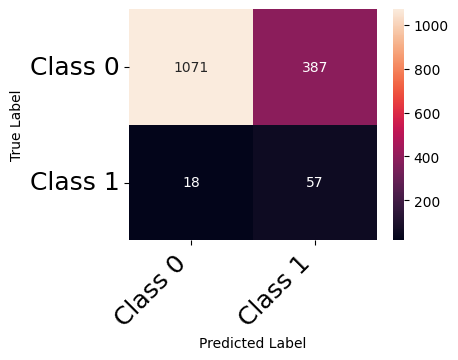

In [62]:
perceptron = Perceptron()
perceptron.fit(X_train_blsmote_scaled, y_blsmote)
print(perceptron.score(X_test_blsmote_scaled, y_test))
print_confusion_matrix(confusion_matrix(y_test, perceptron.predict(X_test_blsmote_scaled,)), ['Class 0', 'Class 1'])

In [63]:
evaluate_model(perceptron, X_test_blsmote_scaled, y_test, pred_label=1)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 1,0.736,0.76,0.128,0.22,0.747


In [64]:
evaluate_model(perceptron, X_test_blsmote_scaled, y_test, pred_label=0)

,Accuracy,Recall,Precision,F1 Score,AUC Score
Class 0,0.736,0.735,0.983,0.841,0.747


In [ ]:
"""
# E- Undersampling

from imblearn.under_sampling import RandomUnderSampler
X_under, y_under = RandomUnderSampler().fit_resample(X_train, y_train)


#-------------------------------------------------------------------------------------------------------------------
rf = RandomForestClassifier()
acc_rf = cross_val_score(rf, X_under, y_under, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
dt = DecisionTreeClassifier() 
acc_dt = cross_val_score(dt, X_under, y_under, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
xgboost = XGBClassifier()
acc_xgboost = cross_val_score(xgboost, X_under, y_under, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------

from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler()
X_train_under_scaled = std_scale.fit_transform(X_under)
X_test_under_scaled = std_scale.transform(X_test)

logreg = LogisticRegression(solver='liblinear')
acc_logreg = cross_val_score(logreg, X_train_under_scaled, y_under, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
knn = KNeighborsClassifier()
acc_knn = cross_val_score(knn, X_train_under_scaled, y_under, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
perceptron = Perceptron()
acc_perc = cross_val_score(perceptron, X_train_under_scaled, y_under, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
svc = SVC()
acc_svc = cross_val_score(svc, X_train_under_scaled, y_under, cv=5, scoring='accuracy')

#-------------------------------------------------------------------------------------------------------------------
results = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree', 'XGBoost',
              'Logistic Regression', 'KNN', 'Perceptron', 'SVC'],
    'Cross Validated Score (Mean)': [acc_rf.mean(), acc_dt.mean(), acc_xgboost.mean(), acc_logreg.mean(),
                                     acc_knn.mean(), acc_perc.mean(), acc_svc.mean()],
    'Cross Validated Score (Std)': [acc_rf.std(), acc_dt.std(), acc_xgboost.std(), acc_logreg.std(),
                                    acc_knn.std(), acc_perc.std(), acc_svc.std()]})

result_df = results.sort_values(by='Cross Validated Score (Mean)', ascending=False)
result_df = result_df.set_index('Model')
result_df['Cross Validated Score (Mean)'] = (result_df['Cross Validated Score (Mean)']*100).round(2)
result_df['Cross Validated Score (Std)'] = (result_df['Cross Validated Score (Std)']*100).round(2)
result_df
"""

In [65]:
# Import pickle Package
import pickle

In [66]:
Pkl_Filename = "Pickle_Stoke_Prediction_Model_Perceptron.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(perceptron, file)